In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:57 - loss: 0.0397 - STD: 2.3355e-04 - MAE: 0.1908

 4/74 [>.............................] - ETA: 1s - loss: 0.0282 - STD: 2.8543e-04 - MAE: 0.1288  

 5/74 [=>............................] - ETA: 2s - loss: 0.0279 - STD: 2.7382e-04 - MAE: 0.1277

 6/74 [=>............................] - ETA: 2s - loss: 0.0269 - STD: 2.7250e-04 - MAE: 0.1231

 7/74 [=>............................] - ETA: 2s - loss: 0.0253 - STD: 2.8177e-04 - MAE: 0.1155

 8/74 [==>...........................] - ETA: 2s - loss: 0.0236 - STD: 2.9853e-04 - MAE: 0.1088

 9/74 [==>...........................] - ETA: 3s - loss: 0.0225 - STD: 3.1995e-04 - MAE: 0.1068

10/74 [===>..........................] - ETA: 3s - loss: 0.0219 - STD: 3.4199e-04 - MAE: 0.1074

11/74 [===>..........................] - ETA: 3s - loss: 0.0215 - STD: 3.6289e-04 - MAE: 0.1086

12/74 [===>..........................] - ETA: 3s - loss: 0.0211 - STD: 3.8189e-04 - MAE: 0.1089

13/74 [====>.........................] - ETA: 3s - loss: 0.0205 - STD: 3.9870e-04 - MAE: 0.1079

14/74 [====>.........................] - ETA: 3s - loss: 0.0199 - STD: 4.1293e-04 - MAE: 0.1057

15/74 [=====>........................] - ETA: 3s - loss: 0.0194 - STD: 4.2448e-04 - MAE: 0.1030

16/74 [=====>........................] - ETA: 3s - loss: 0.0190 - STD: 4.3375e-04 - MAE: 0.1002

17/74 [=====>........................] - ETA: 3s - loss: 0.0187 - STD: 4.4181e-04 - MAE: 0.0980

18/74 [======>.......................] - ETA: 2s - loss: 0.0184 - STD: 4.5004e-04 - MAE: 0.0962

19/74 [======>.......................] - ETA: 2s - loss: 0.0182 - STD: 4.5873e-04 - MAE: 0.0945

20/74 [=======>......................] - ETA: 2s - loss: 0.0180 - STD: 4.6840e-04 - MAE: 0.0930

21/74 [=======>......................] - ETA: 2s - loss: 0.0178 - STD: 4.7975e-04 - MAE: 0.0914

22/74 [=======>......................] - ETA: 2s - loss: 0.0175 - STD: 4.9270e-04 - MAE: 0.0900

23/74 [========>.....................] - ETA: 2s - loss: 0.0173 - STD: 5.0740e-04 - MAE: 0.0891

24/74 [========>.....................] - ETA: 2s - loss: 0.0170 - STD: 5.2328e-04 - MAE: 0.0886

25/74 [=========>....................] - ETA: 2s - loss: 0.0168 - STD: 5.4006e-04 - MAE: 0.0884

26/74 [=========>....................] - ETA: 2s - loss: 0.0167 - STD: 5.5738e-04 - MAE: 0.0884

27/74 [=========>....................] - ETA: 2s - loss: 0.0166 - STD: 5.7481e-04 - MAE: 0.0884

28/74 [==========>...................] - ETA: 2s - loss: 0.0164 - STD: 5.9202e-04 - MAE: 0.0883

29/74 [==========>...................] - ETA: 2s - loss: 0.0163 - STD: 6.0895e-04 - MAE: 0.0879

30/74 [===========>..................] - ETA: 2s - loss: 0.0161 - STD: 6.2559e-04 - MAE: 0.0874

31/74 [===========>..................] - ETA: 2s - loss: 0.0160 - STD: 6.4166e-04 - MAE: 0.0867

32/74 [===========>..................] - ETA: 2s - loss: 0.0159 - STD: 6.5760e-04 - MAE: 0.0859

33/74 [============>.................] - ETA: 2s - loss: 0.0158 - STD: 6.7391e-04 - MAE: 0.0852

34/74 [============>.................] - ETA: 2s - loss: 0.0157 - STD: 6.9042e-04 - MAE: 0.0844

35/74 [=============>................] - ETA: 2s - loss: 0.0156 - STD: 7.0805e-04 - MAE: 0.0838

36/74 [=============>................] - ETA: 2s - loss: 0.0155 - STD: 7.2712e-04 - MAE: 0.0832

37/74 [==============>...............] - ETA: 2s - loss: 0.0154 - STD: 7.4722e-04 - MAE: 0.0826

38/74 [==============>...............] - ETA: 2s - loss: 0.0153 - STD: 7.6952e-04 - MAE: 0.0822

39/74 [==============>...............] - ETA: 1s - loss: 0.0152 - STD: 7.9385e-04 - MAE: 0.0819

40/74 [===============>..............] - ETA: 1s - loss: 0.0151 - STD: 8.2027e-04 - MAE: 0.0818

41/74 [===============>..............] - ETA: 1s - loss: 0.0151 - STD: 8.4797e-04 - MAE: 0.0817

42/74 [================>.............] - ETA: 1s - loss: 0.0150 - STD: 8.7647e-04 - MAE: 0.0816

43/74 [================>.............] - ETA: 1s - loss: 0.0149 - STD: 9.0669e-04 - MAE: 0.0815

44/74 [================>.............] - ETA: 1s - loss: 0.0149 - STD: 9.3801e-04 - MAE: 0.0814

45/74 [=================>............] - ETA: 1s - loss: 0.0148 - STD: 9.6997e-04 - MAE: 0.0811

46/74 [=================>............] - ETA: 1s - loss: 0.0147 - STD: 0.0010 - MAE: 0.0808    

47/74 [==================>...........] - ETA: 1s - loss: 0.0147 - STD: 0.0010 - MAE: 0.0805

48/74 [==================>...........] - ETA: 1s - loss: 0.0146 - STD: 0.0011 - MAE: 0.0801

49/74 [==================>...........] - ETA: 1s - loss: 0.0145 - STD: 0.0011 - MAE: 0.0798

50/74 [===================>..........] - ETA: 1s - loss: 0.0145 - STD: 0.0012 - MAE: 0.0794

51/74 [===================>..........] - ETA: 1s - loss: 0.0144 - STD: 0.0012 - MAE: 0.0791

52/74 [====================>.........] - ETA: 1s - loss: 0.0143 - STD: 0.0012 - MAE: 0.0788

53/74 [====================>.........] - ETA: 1s - loss: 0.0143 - STD: 0.0013 - MAE: 0.0785

54/74 [====================>.........] - ETA: 1s - loss: 0.0142 - STD: 0.0014 - MAE: 0.0783

55/74 [=====================>........] - ETA: 1s - loss: 0.0142 - STD: 0.0014 - MAE: 0.0782

56/74 [=====================>........] - ETA: 1s - loss: 0.0141 - STD: 0.0015 - MAE: 0.0780

57/74 [======================>.......] - ETA: 0s - loss: 0.0141 - STD: 0.0015 - MAE: 0.0779

58/74 [======================>.......] - ETA: 0s - loss: 0.0141 - STD: 0.0016 - MAE: 0.0778

59/74 [======================>.......] - ETA: 0s - loss: 0.0140 - STD: 0.0017 - MAE: 0.0777

60/74 [=======================>......] - ETA: 0s - loss: 0.0140 - STD: 0.0018 - MAE: 0.0775

61/74 [=======================>......] - ETA: 0s - loss: 0.0139 - STD: 0.0019 - MAE: 0.0774

62/74 [========================>.....] - ETA: 0s - loss: 0.0139 - STD: 0.0020 - MAE: 0.0771

63/74 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 0.0021 - MAE: 0.0769

64/74 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 0.0022 - MAE: 0.0767

65/74 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 0.0023 - MAE: 0.0764

66/74 [=========================>....] - ETA: 0s - loss: 0.0137 - STD: 0.0025 - MAE: 0.0762

67/74 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.0026 - MAE: 0.0760

68/74 [==========================>...] - ETA: 0s - loss: 0.0136 - STD: 0.0028 - MAE: 0.0759

69/74 [==========================>...] - ETA: 0s - loss: 0.0135 - STD: 0.0030 - MAE: 0.0757

70/74 [===========================>..] - ETA: 0s - loss: 0.0135 - STD: 0.0032 - MAE: 0.0755

71/74 [===========================>..] - ETA: 0s - loss: 0.0134 - STD: 0.0034 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0133 - STD: 0.0042 - MAE: 0.0747

74/74 [==============================] - 7s 75ms/step - loss: 0.0133 - STD: 0.0042 - MAE: 0.0747 - val_loss: 0.0104 - val_STD: 0.0186 - val_MAE: 0.0584


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0088 - STD: 0.0273 - MAE: 0.0566

 2/74 [..............................] - ETA: 4s - loss: 0.0085 - STD: 0.0286 - MAE: 0.0558

 3/74 [>.............................] - ETA: 4s - loss: 0.0085 - STD: 0.0303 - MAE: 0.0560

 4/74 [>.............................] - ETA: 4s - loss: 0.0083 - STD: 0.0319 - MAE: 0.0557

 5/74 [=>............................] - ETA: 4s - loss: 0.0081 - STD: 0.0337 - MAE: 0.0554

 6/74 [=>............................] - ETA: 4s - loss: 0.0080 - STD: 0.0354 - MAE: 0.0549

 7/74 [=>............................] - ETA: 4s - loss: 0.0078 - STD: 0.0372 - MAE: 0.0546

 8/74 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.0389 - MAE: 0.0540

 9/74 [==>...........................] - ETA: 3s - loss: 0.0075 - STD: 0.0406 - MAE: 0.0535

10/74 [===>..........................] - ETA: 3s - loss: 0.0074 - STD: 0.0425 - MAE: 0.0532

11/74 [===>..........................] - ETA: 3s - loss: 0.0073 - STD: 0.0444 - MAE: 0.0527

12/74 [===>..........................] - ETA: 3s - loss: 0.0071 - STD: 0.0463 - MAE: 0.0523

13/74 [====>.........................] - ETA: 3s - loss: 0.0070 - STD: 0.0481 - MAE: 0.0519

14/74 [====>.........................] - ETA: 3s - loss: 0.0068 - STD: 0.0498 - MAE: 0.0515

15/74 [=====>........................] - ETA: 3s - loss: 0.0067 - STD: 0.0514 - MAE: 0.0511

16/74 [=====>........................] - ETA: 3s - loss: 0.0066 - STD: 0.0530 - MAE: 0.0507

17/74 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.0545 - MAE: 0.0503

18/74 [======>.......................] - ETA: 3s - loss: 0.0063 - STD: 0.0560 - MAE: 0.0499

19/74 [======>.......................] - ETA: 3s - loss: 0.0062 - STD: 0.0574 - MAE: 0.0495

20/74 [=======>......................] - ETA: 3s - loss: 0.0061 - STD: 0.0586 - MAE: 0.0491

21/74 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.0596 - MAE: 0.0487

22/74 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0607 - MAE: 0.0483

23/74 [========>.....................] - ETA: 3s - loss: 0.0058 - STD: 0.0617 - MAE: 0.0479

24/74 [========>.....................] - ETA: 2s - loss: 0.0057 - STD: 0.0628 - MAE: 0.0476

25/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0638 - MAE: 0.0473

26/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0469

27/74 [=========>....................] - ETA: 2s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0466

28/74 [==========>...................] - ETA: 2s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0463

29/74 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0685 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0694 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0702 - MAE: 0.0453

33/74 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0710 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0716 - MAE: 0.0447

35/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0722 - MAE: 0.0445

36/74 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0728 - MAE: 0.0443

37/74 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0733 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0740 - MAE: 0.0439

39/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0746 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0047 - STD: 0.0751 - MAE: 0.0435

41/74 [===============>..............] - ETA: 1s - loss: 0.0047 - STD: 0.0756 - MAE: 0.0433

42/74 [================>.............] - ETA: 1s - loss: 0.0047 - STD: 0.0760 - MAE: 0.0431

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0771 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0776 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0779 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0783 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0786 - MAE: 0.0422

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0790 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0794 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0796 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0799 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0801 - MAE: 0.0416

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0805 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0807 - MAE: 0.0413

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0810 - MAE: 0.0412

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0812 - MAE: 0.0411

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0815 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0818 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0820 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0821 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0823 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0825 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0827 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0829 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0830 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0832 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0834 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0836 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0838 - MAE: 0.0399

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0839 - MAE: 0.0398

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0841 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0842 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0844 - MAE: 0.0396

74/74 [==============================] - 5s 62ms/step - loss: 0.0039 - STD: 0.0844 - MAE: 0.0396 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0334


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0909 - MAE: 0.0340

 2/74 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0939 - MAE: 0.0341

 3/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0943 - MAE: 0.0341

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0946 - MAE: 0.0342

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0946 - MAE: 0.0341

 6/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0342

 7/74 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0947 - MAE: 0.0341

 8/74 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0947 - MAE: 0.0341

 9/74 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.0948 - MAE: 0.0341

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0950 - MAE: 0.0341

11/74 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0340

12/74 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.0954 - MAE: 0.0340

13/74 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0340

14/74 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0956 - MAE: 0.0339

15/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0339

16/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0338

17/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0338

18/74 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0338

19/74 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0338

20/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0337

21/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0337

22/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0337

23/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0337

24/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0336

25/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0336

26/74 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0336

27/74 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0336

28/74 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0335

29/74 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0335

30/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0335

31/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0335

33/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0335

34/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0964 - MAE: 0.0335

35/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0334

36/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0334

37/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0334

38/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0334

39/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0334

40/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0333

41/74 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0333

42/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0333

43/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0333

44/74 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0333

45/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0333

46/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0333

47/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0332

48/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0332

49/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0332

50/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0332

51/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

52/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

53/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

54/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

55/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0331

56/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0330

57/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

58/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0330

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0329

63/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0329

64/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0329

65/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0329

66/74 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0329

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0329

68/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0329

69/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0328

70/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

71/74 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

72/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

74/74 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328

74/74 [==============================] - 5s 62ms/step - loss: 0.0025 - STD: 0.0967 - MAE: 0.0328 - val_loss: 0.0032 - val_STD: 0.0655 - val_MAE: 0.0325


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0024 - STD: 0.0930 - MAE: 0.0317

 2/74 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0952 - MAE: 0.0315

 3/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0967 - MAE: 0.0318

 4/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0954 - MAE: 0.0316

 5/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0959 - MAE: 0.0316

 6/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0317

 7/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0971 - MAE: 0.0316

 8/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0969 - MAE: 0.0316

 9/74 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0317

10/74 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0317

11/74 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0316

12/74 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0316

13/74 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0316

14/74 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0316

15/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0315

16/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0315

17/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

18/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

19/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

20/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0314

21/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0313

23/74 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0313

24/74 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

25/74 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0312

26/74 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0312

27/74 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

28/74 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0312

29/74 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

30/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

31/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

32/74 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

33/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

34/74 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0311

35/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

36/74 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

37/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0311

38/74 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

39/74 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0310

40/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

41/74 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

42/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

43/74 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0310

44/74 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0310

45/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

46/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

47/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

48/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

49/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

50/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

51/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

52/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

53/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

54/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

55/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0309

56/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

57/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

58/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0309

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0309

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0308

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0308

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0307

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0307

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0307

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0307

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0307

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0307

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0307

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0307

74/74 [==============================] - 4s 59ms/step - loss: 0.0022 - STD: 0.0980 - MAE: 0.0307 - val_loss: 0.0028 - val_STD: 0.0716 - val_MAE: 0.0310


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0301

 2/74 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0300

 3/74 [>.............................] - ETA: 5s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0301

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0300

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0302

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0300

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0299

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

 9/74 [==>...........................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0297

10/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

11/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

12/74 [===>..........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

13/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

14/74 [====>.........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

17/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0296

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0297

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0297

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0297

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0297

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0297

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0296

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0296

26/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0296

27/74 [=========>....................] - ETA: 2s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0297

28/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0297

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0298

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0297

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0297

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0297

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0298

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

37/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0298

38/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

39/74 [==============>...............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

40/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0297

41/74 [===============>..............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

42/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

43/74 [================>.............] - ETA: 2s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

44/74 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

45/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

46/74 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

47/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

48/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

49/74 [==================>...........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

50/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

51/74 [===================>..........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

52/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

53/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

54/74 [====================>.........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

55/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0297

56/74 [=====================>........] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

57/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

58/74 [======================>.......] - ETA: 1s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

59/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

63/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

65/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

69/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

71/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0298

74/74 [==============================] - 5s 66ms/step - loss: 0.0021 - STD: 0.0990 - MAE: 0.0298 - val_loss: 0.0030 - val_STD: 0.0710 - val_MAE: 0.0322


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0299

 2/74 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0294

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0293

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0293

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0293

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0292

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0291

 9/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0291

10/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0291

11/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

12/74 [===>..........................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0291

13/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0291

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0291

16/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0291

18/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0291

19/74 [======>.......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

20/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

21/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0291

22/74 [=======>......................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0291

23/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0291

24/74 [========>.....................] - ETA: 3s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0292

25/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

26/74 [=========>....................] - ETA: 3s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0292

27/74 [=========>....................] - ETA: 2s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0292

28/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0992 - MAE: 0.0292

29/74 [==========>...................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

30/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0293

35/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

36/74 [=============>................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0294

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0294

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0292

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0292

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0293

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293

74/74 [==============================] - 5s 68ms/step - loss: 0.0020 - STD: 0.0996 - MAE: 0.0293 - val_loss: 0.0031 - val_STD: 0.0692 - val_MAE: 0.0325


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0294

 2/74 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0304

 3/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0973 - MAE: 0.0298

 4/74 [>.............................] - ETA: 4s - loss: 0.0020 - STD: 0.0979 - MAE: 0.0295

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0982 - MAE: 0.0295

 6/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0293

 7/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0292

 8/74 [==>...........................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0292

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0290

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0289

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.0987 - MAE: 0.0288

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0989 - MAE: 0.0289

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0288

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0288

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0288

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0288

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0287

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0288

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0288

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0288

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

25/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0288

26/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

27/74 [=========>....................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0290

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0290

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0290

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

43/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0289

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0289

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0289

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0289

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289

74/74 [==============================] - 5s 68ms/step - loss: 0.0019 - STD: 0.0998 - MAE: 0.0289 - val_loss: 0.0027 - val_STD: 0.0726 - val_MAE: 0.0307


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0020 - STD: 0.0991 - MAE: 0.0289

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0986 - MAE: 0.0289

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0985 - MAE: 0.0287

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0285

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0287

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0286

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0286

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0286

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0993 - MAE: 0.0288

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

13/74 [====>.........................] - ETA: 4s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0291

14/74 [====>.........................] - ETA: 3s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0290

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288 - val_loss: 0.0026 - val_STD: 0.0744 - val_MAE: 0.0312


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.0979 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0984 - MAE: 0.0283

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0286

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

10/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0287

11/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0286

12/74 [===>..........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0286

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0286

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0285

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

28/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0287

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0288

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0288

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1003 - MAE: 0.0288 - val_loss: 0.0025 - val_STD: 0.0764 - val_MAE: 0.0316


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1034 - MAE: 0.0290

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0285

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0285

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

13/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0284

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0284

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0284

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0285

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0284

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0284

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0285

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0285

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286

74/74 [==============================] - 5s 69ms/step - loss: 0.0019 - STD: 0.1004 - MAE: 0.0286 - val_loss: 0.0025 - val_STD: 0.0750 - val_MAE: 0.0315


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0296

 2/74 [..............................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1028 - MAE: 0.0286

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1021 - MAE: 0.0289

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1024 - MAE: 0.0289

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1018 - MAE: 0.0287

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0285

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1014 - MAE: 0.0286

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1011 - MAE: 0.0285

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1012 - MAE: 0.0285

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0284

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0285

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.1009 - MAE: 0.0285

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0284

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0284

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0283

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0283

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0283

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0284

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0283

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0283

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0282

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0283 - val_loss: 0.0026 - val_STD: 0.0741 - val_MAE: 0.0300


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0273

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1022 - MAE: 0.0279

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0774 - val_MAE: 0.0332


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0308

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0978 - MAE: 0.0304

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0983 - MAE: 0.0295

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0296

 5/74 [=>............................] - ETA: 4s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0297

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0294

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0293

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0293

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0293

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0292

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0291

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0289

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0289

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0288

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0288

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0287

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0287

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0287

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0286

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

44/74 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0286

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0285

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0283

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282 - val_loss: 0.0025 - val_STD: 0.0757 - val_MAE: 0.0303


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0275

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0276

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0281

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0280

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

43/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

74/74 [==============================] - 5s 67ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278 - val_loss: 0.0026 - val_STD: 0.0735 - val_MAE: 0.0301


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0959 - MAE: 0.0277

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0995 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1000 - MAE: 0.0274

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0274

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0275

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0276

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0276

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0278

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0280

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0278

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0279

27/74 [=========>....................] - ETA: 2s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0279

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

74/74 [==============================] - 5s 68ms/step - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280 - val_loss: 0.0025 - val_STD: 0.0778 - val_MAE: 0.0322


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1017 - MAE: 0.0294

 3/74 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0285

 4/74 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1021 - MAE: 0.0283

 5/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0282

 6/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1025 - MAE: 0.0282

 7/74 [=>............................] - ETA: 3s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0281

 8/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0281

10/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

11/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

12/74 [===>..........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0278

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0278

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0277

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1012 - MAE: 0.0277 - val_loss: 0.0028 - val_STD: 0.0726 - val_MAE: 0.0306


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0018 - STD: 0.0961 - MAE: 0.0275

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0283

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0981 - MAE: 0.0282

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0282

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0281

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0999 - MAE: 0.0279

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0279

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0281

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0281

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0280

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0281

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0286

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0286

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0287

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0285

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279 - val_loss: 0.0025 - val_STD: 0.0770 - val_MAE: 0.0309


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1032 - MAE: 0.0283

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0279

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0278

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0276

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0278

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0278

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

74/74 [==============================] - 5s 69ms/step - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278 - val_loss: 0.0024 - val_STD: 0.0773 - val_MAE: 0.0298


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0275

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1032 - MAE: 0.0273

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0276

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0275

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0278

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0277

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0277

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0284

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0284

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0283

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0284

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

28/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0283

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0282

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

59/74 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277 - val_loss: 0.0025 - val_STD: 0.0753 - val_MAE: 0.0297


Epoch 20/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0992 - MAE: 0.0272

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1022 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0275

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0273

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0277

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0275

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0275

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0275

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0276

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

74/74 [==============================] - 5s 68ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277 - val_loss: 0.0026 - val_STD: 0.0733 - val_MAE: 0.0294


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0991 - MAE: 0.0270

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0275

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0272

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0273

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0273

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0271

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0272

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0273

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0273

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274 - val_loss: 0.0025 - val_STD: 0.0762 - val_MAE: 0.0302


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0271

 2/74 [..............................] - ETA: 5s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0276

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1019 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0278

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1026 - MAE: 0.0280

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0280

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0279

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1020 - MAE: 0.0280

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0280

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0280

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0279

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0280

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0280

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0280

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0279

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0279

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0279

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0279

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0279

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0277

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0277

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277 - val_loss: 0.0025 - val_STD: 0.0769 - val_MAE: 0.0297


Epoch 23/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0268

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0267

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1030 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1027 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0267

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0267

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0267

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0268

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0268

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0269

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0269

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0269

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0269

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0269

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0276

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275 - val_loss: 0.0026 - val_STD: 0.0740 - val_MAE: 0.0296


Epoch 24/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0998 - MAE: 0.0263

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.0993 - MAE: 0.0265

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0271

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0270

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0270

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0271

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

28/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0270

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0270

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0271

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1013 - MAE: 0.0273 - val_loss: 0.0025 - val_STD: 0.0780 - val_MAE: 0.0305


Epoch 25/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0279

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0269

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0274

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0275

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0274

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0274

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0274

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0276

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0278

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0276

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0276

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0276

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0275

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0275

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0274

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0273

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0273

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0272

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272

74/74 [==============================] - 5s 69ms/step - loss: 0.0017 - STD: 0.1014 - MAE: 0.0272 - val_loss: 0.0025 - val_STD: 0.0776 - val_MAE: 0.0303


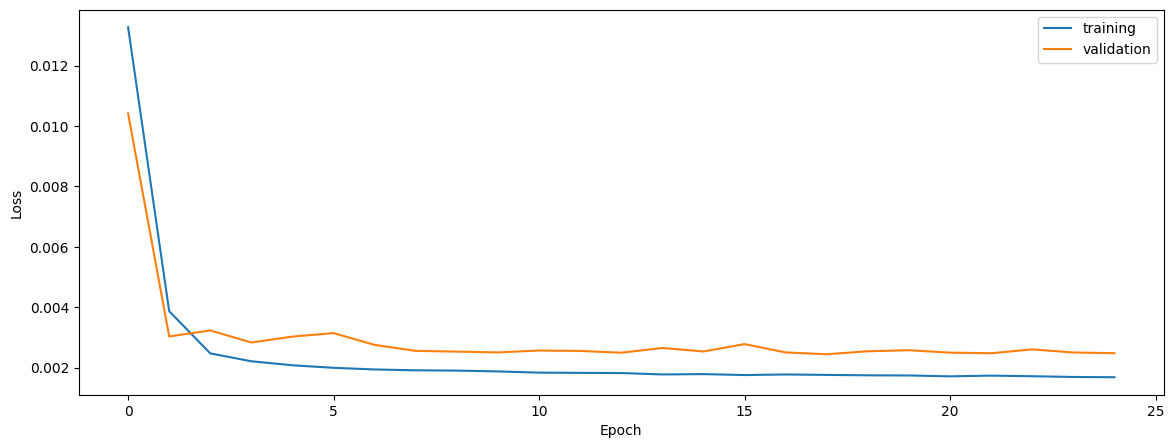

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


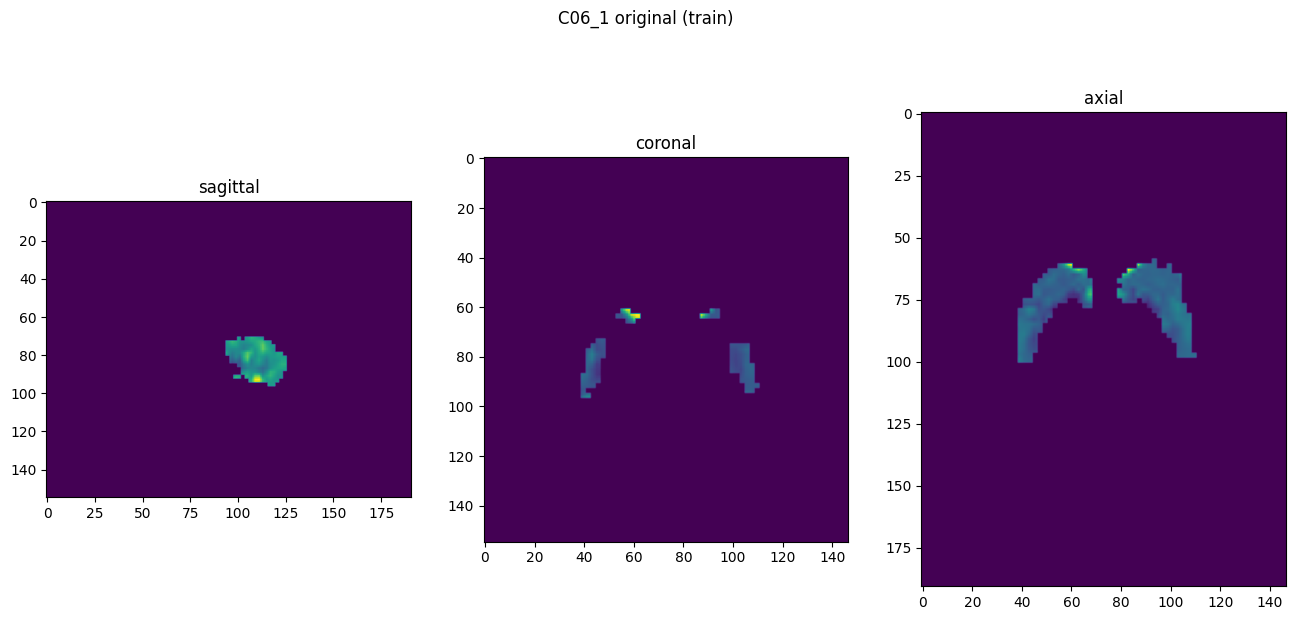

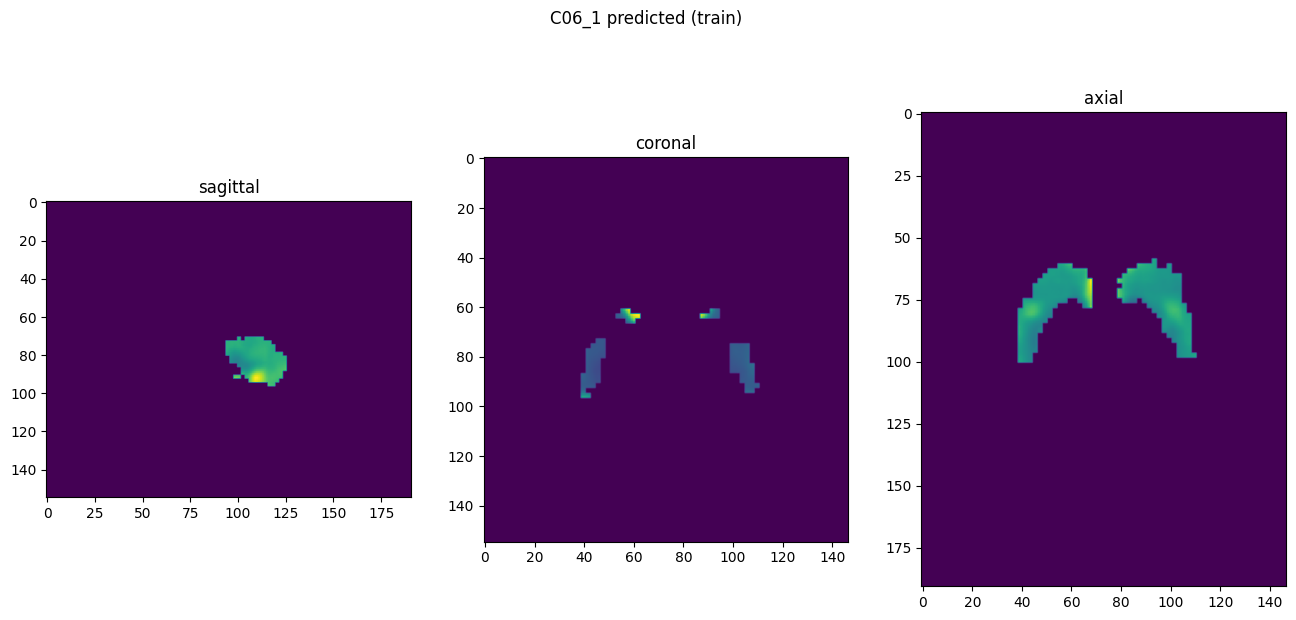

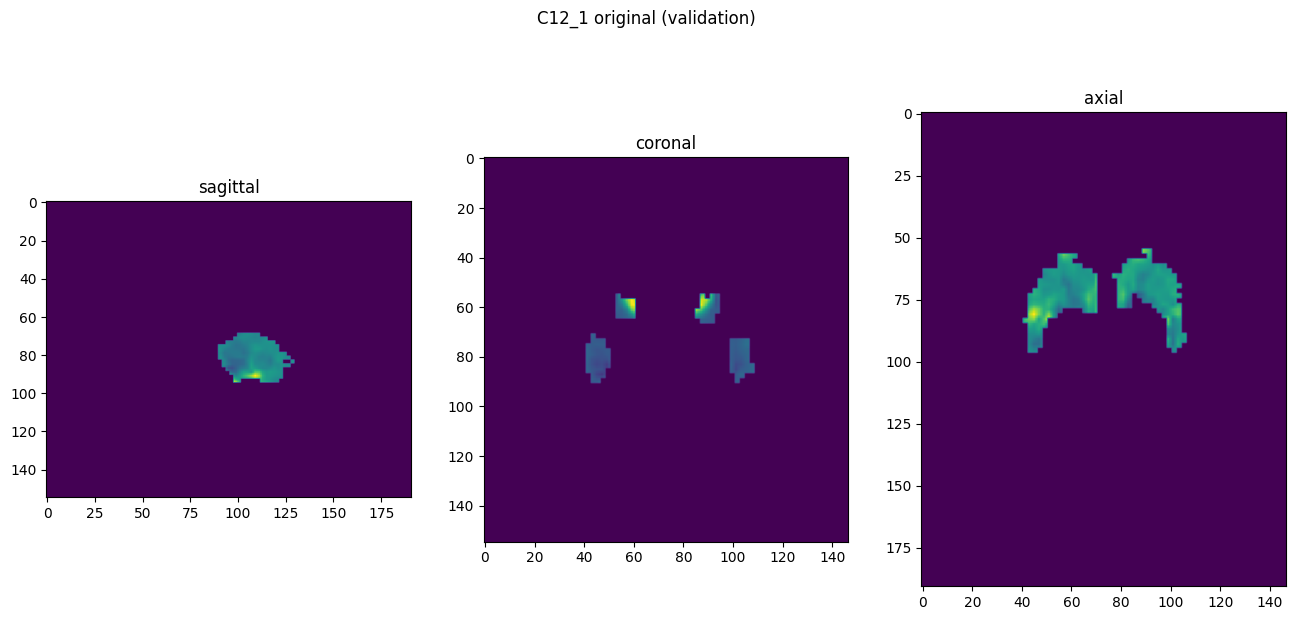

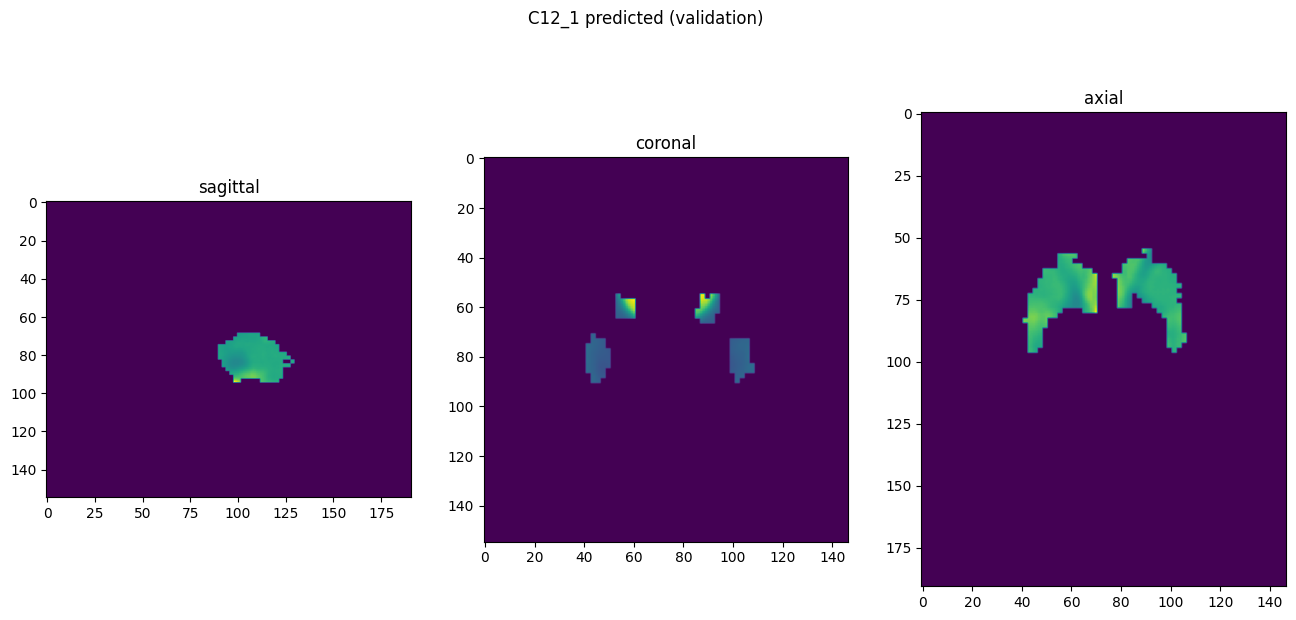

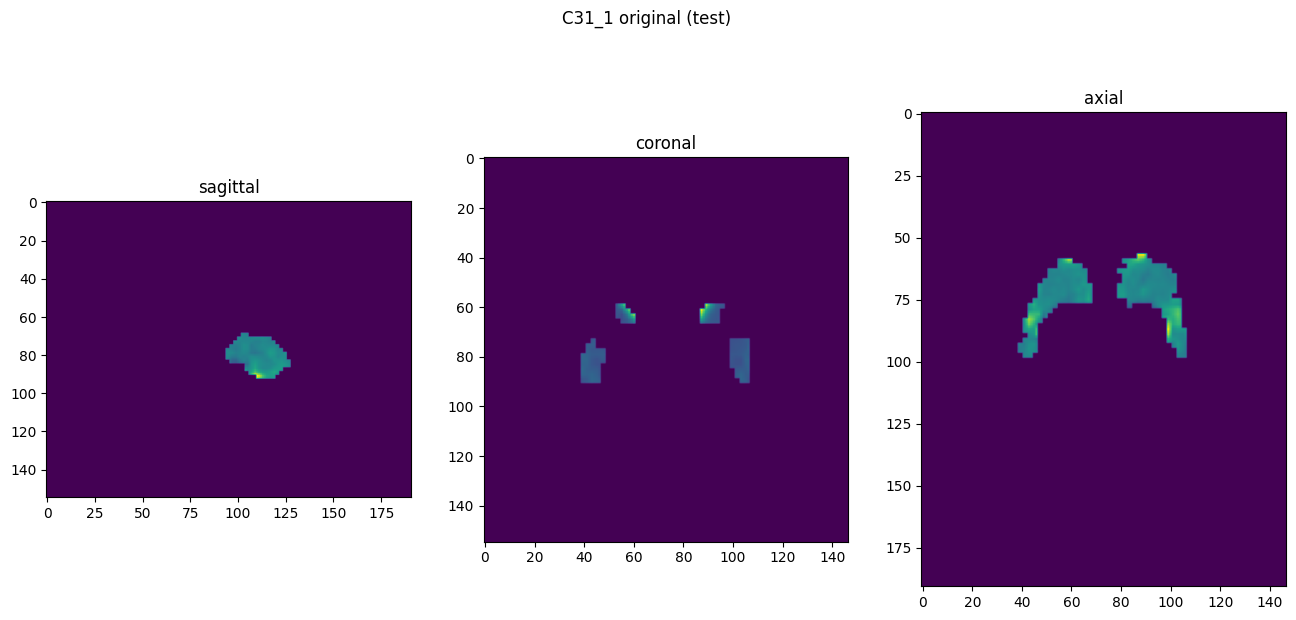

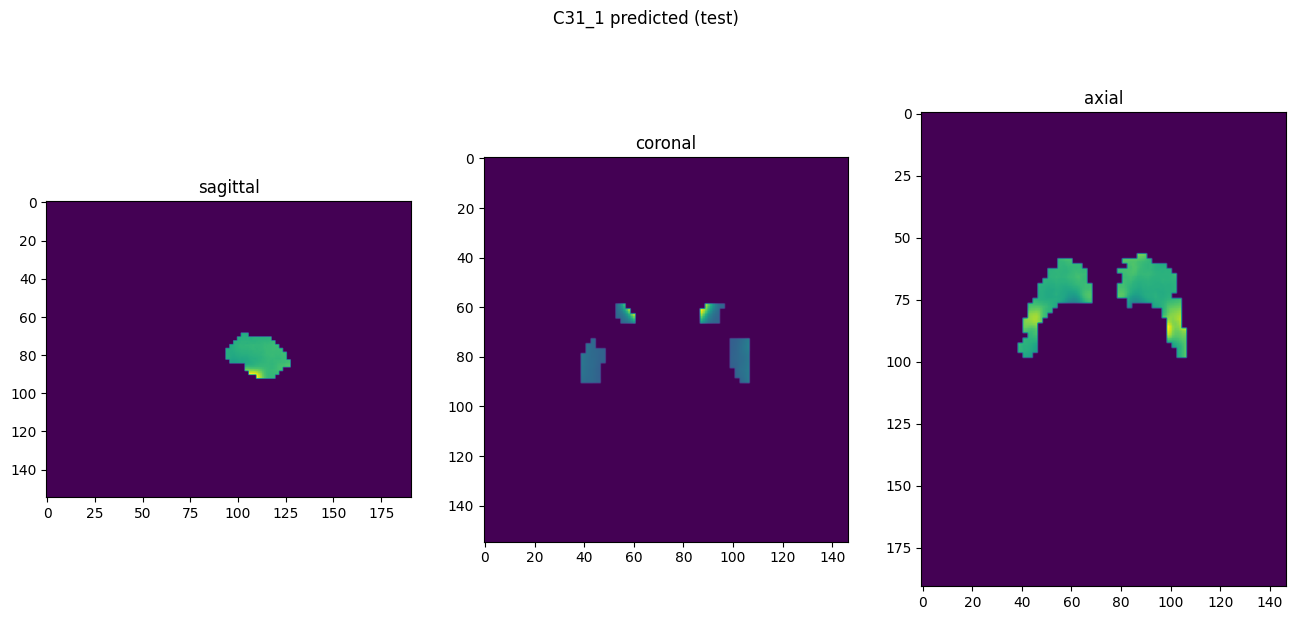

In [10]:
showResults(model, gen, threshold=None, background=False)